### Εργαστηριακή Άσκηση 6 FSK-MSK


1. Να συμπληρωθεί  ο παρακάτω κώδικας  των σημειώσεων ώστε να εξομοιώνει και την
ασύμφωνη FSK (υπόδειξη: προσθέστε τυχαία φάση στο λαμβανόμενο σήμα, πριν
την αποδιαμόρφωση-φώραση).
2. Χρησιμοποιείστε τη νέα σας συνάρτηση για εξομοίωση συστήματος 16-FSK και
σχεδιάστε τις καμπύλες Pb<-> Eb/No για σύμφωνη και ασύμφωνη
αποδιαμόρφωση (θεωρητικές και από εξομοίωση)

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy.io
import scipy.signal


from math import log
from scipy import signal
from scipy.signal import upfirdn, decimate
from scipy.special import erfc

In [52]:
def bin2int(binary):
    """Converts binary as list to integer.

    Args:
        binary (np.array | list[ints]): binary number as array of ints

    Returns:
        integer (int): result of conversion
    """
    list_as_str = ''.join(str(e) for e in binary)
    return int(list_as_str, 2)
    

def int2bin(x, pad):
    num = bin(x).replace("0b", "")  # 9 = '0b1001'
    num = f'{num:0>{pad}}' # zero-pads to the right
    return [int(d) for d in num]


def addAWGN(sig, SNR_dB):
    """Add white gaussian noise to the signal.

    Args:
        sig (np.array): signal
        SNR_dB (float): target signal-to-noise ratio in dB

    Returns:
        y_noisy (np.array): noisy signal
    """

    # Calculate signal power and convert to dB
    sig_avg_watts = np.mean(sig**2)

    sig_avg_db = 10 * np.log10(sig_avg_watts)

    # SNR_dB = Psignal_dB - Pnoise_dB
    noise_avg_db = sig_avg_db - SNR_dB
    noise_avg_watts = 10 ** (noise_avg_db / 10)

    # Generate an sample of white noise
    mean_noise = 0
    noise_volts = np.random.normal(
        mean_noise, np.sqrt(noise_avg_watts), len(sig))

    # Noise up the original signal
    y_noisy = sig + noise_volts

    return y_noisy


In [112]:
def fsk_errors(bps, Nsymb, ns, EbNo, coherence=True):
    """Calculates errors on transmision w/ (non- ) coherent detection.

    Args:
        bps (int): bits per symbol
        Nsymb (int): Number of symbols
        ns (int): Number of samples per symbol (oversampling)
        EbNo (int): SNR per bit
        coherence (bool, optional): Coherent detection. Defaults to True.

    Returns:
        errors (int): Errors on transmision
    """

    M = 2 ** bps # number of different symbols
    BR = 1 # Baud Rate
    fc = 2 * M * BR # RF frequency
    
    # Derived parameters
    nb = bps * Nsymb # number of simulated data bits
    T = 1 / BR # one symbol period
    Ts = T / ns # oversampling period
    
    # M frequencies in "non-coherent" distance (BR)
    f = fc + BR * (np.arange(1, M+1) - (M+1)/2)
    
    # AWGN channel in db
    SNR = EbNo + 10*np.log10(bps) - 10*np.log10(ns/2)
    
    # input data bits and .T = transpose
    x = np.random.randint(2, size=(bps, Nsymb)).T
    tks = np.arange(0, T, Ts).T

    # Sender: FSK signal
    s = np.empty(shape=(x.shape[0], tks.shape[0]))
    A = np.sqrt(2/T/ns)
    for k in range(x.shape[0]):
        idx = bin2int(x[k, :])
        fk = f[idx]
        tk = k * T + tks
        s[k] = np.sin(2 * np.pi * fk * tk)

    # add noise to the FSK (passband) signal
    s_noise = addAWGN(s.flatten(), SNR)

    # Receiver: FSK signal
    xr = np.empty(x.shape)
    for k in range(Nsymb):
        tk = k * T + tks
        sk = s_noise[k * ns : (k+1) * ns]
        
        sm = np.empty(M)
        for i in range(M):
            if coherence:
                si = np.sin(2*np.pi*f[i]*tk)
                sm[i] = np.sum(sk * si)
            if not coherence:
                th = np.random.normal() # random phase on receiver
                si = np.sin(2 * np.pi * (f[i]*tk + th))
                sq = np.cos(2 * np.pi * (f[i]*tk + th))
                smi = np.sum(sk * si)
                smq = np.sum(sk * sq)
                sm[i] = np.sqrt(smi**2 + smq**2)

        idx_max = np.argmax(sm)
        bits = int2bin(idx_max, bps)

        xr[k, :] = [d for d in bits]

    # count errors
    return s, np.count_nonzero(x.flatten()-xr.flatten())


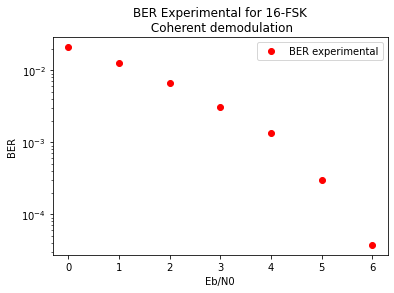

In [113]:
bps = 4
Nsymb = 10000
ns = 16
EbNo = np.arange(7)

ber = np.empty(EbNo.shape)
ber_theory = np.empty(EbNo.shape)
coherence = True
for ebno in EbNo:
    res = fsk_errors(bps, Nsymb, ns, ebno, coherence)
    ber[ebno] = res[1] / (ns*Nsymb)
plt.semilogy(EbNo, ber, 'ro', label='BER experimental')
# plt.semilogy(EbNo, ber_theory, 'k', label='BER theoretical')
plt.xlabel('Eb/N0')
plt.ylabel('BER')
plt.title(f'BER Experimental for {2**bps}-FSK\n{"" if coherence else "Not"} Coherent demodulation')
plt.legend()

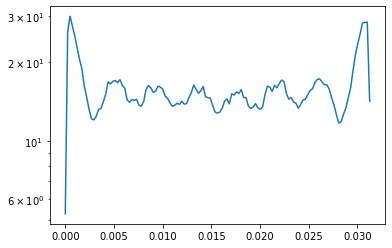

In [104]:
sig = fsk_errors(bps, Nsymb, ns, ebno, coherence)[0].flatten()
f, welch = scipy.signal.welch(sig, 1/ns)
plt.semilogy(f, welch)


### BONUS
Με βάση τον Κώδικα 6.2 των σημειώσεων, να εξομοιωθεί σύστημα MSK μετάδοσης σε ζωνοπερατό δίαυλο με κεντρική συχνότητα 8 ΜΗz και ρυθμό μετάδοσης 2 Mbps. Να σχεδιάσετε το φάσμα του ζωνοπερατού σήματος και να υπολογίσετε (θεωρητικά και με εξομοίωση) το BER, όταν Eb/No=10db.

In [5]:
def upsample(x, n, phase=0):
    """ Increases the sample rate of x by inserting
    n - 1 zeros between samples.

    Args:
        x (np.array): signal to be upsampled
        n (int): upsampling
        phase (int, optional): offset of the unsampled sequence. Defaults to 0.
    Returns:
        y(np.array): upsampled signal
    """
    if x.ndim != 1:
        raise ValueError(f'x.ndim = {x.ndim} > 1.')
    else:
        y = x.T
        y = np.c_[y, np.zeros(shape=(len(x), n-1))]
        y = np.roll(y, phase, axis=1)

        return y.flatten()

In [6]:
def msk_error(Nbits, Nsamp, EbNo, precoding=False):
    # Parameters
    
    n = Nbits # number data bits
    R = 2*(10**6) # bit rate 
    fc = 8/3 * R # carrier frequency
    ns = Nsamp # oversampling factor
    
    # AWGN channel
    SNR = EbNo - 10*np.log10(ns/2) # in db
    
    # Derived Parametres
    T = 1/R #  1 bit period
    Ts = T/ns # sampling frequency
    
    y = np.sign(np.random.random(size=n) - 0.5)  
    # input, n random -1 or 1

    
    x = np.array(
        [y[i]*y[i-1] if i > 0 else 1 for i in range(len(y))]
    ) # [ 1, y[1]*y[0], y[2]*y[1], ...]
    
    g = np.ones(ns)

    xx = np.convolve(upsample(x, ns), g) # size = ns * (n+1)

    # time frame
    ts = np.linspace(0, len(xx)*Ts, len(xx)) 

    # MSK Sender
    xs = xx.copy()
    theta = np.cumsum(xs) * np.pi / 2 /ns
    xs_i = np.cos(theta)
    xs_i = np.append(xs_i, xs_i[-1]) # one more sample
    
    xs_q = np.sin(theta)
    xs_q = np.append(xs_q, xs_q[-1]) # one more sample

    # modulation
    phase = 2 * np.pi * fc * ts
    s = np.dot(
        [xs_i, xs_q],
        [np.cos(phase), (-1) * np.sin(phase)]
    )
    
    pwelch = signal.welch(s, 1/Ts)

    s_noise = addAWGN(s, SNR)

    # MSK receiver
    xs_i = s * np.cos(phase)
    xs_q = -s* np.sin(phase)
    
    # LP filter (Parks-McClellan)
    f1 = 0.75/ns
    f2 = 4*f1

    order = 4*ns
    bands = [0, f1, f2, 1]
    mag = [1, 1, 0, 0]
    wt = [1, 1]

    b = signal.remez(order, bands, mag, wt) # filter coefs
    a = 1

    f_in = np.append(xs_i, np.zeros(order)) # test signal
    f_out = scipy.signal.lfilter(b, a, f_in) # pass it through filter


    for k in range(1, n, 2):
        li = np.arange(k*ns, (k+2)*ns)
        lq = np.arange((k-1)*ns,  (k+1)*ns)

        xi = xs_i[li]
        xq = xs_q[lq]

        gmi = np.cos(np.pi / 2 / T * Ts * li) # παλμός matched-filter
        gmq = -gmi # = np.sin
        
        bi = np.sign(np.sum(xi * gmi))
        bq = np.sign(np.sum(xq * gmq))
        
        bi_1, xr_1 = 1, 1
        xr = np.empty(n)
        if precoding:
            xr[k] = xr_1 * bi_1 * bq
            xr[k+1] = xr[k] * bi * bq
            xr_1 = xr[k+1]
        else:
            xr[k] = bi_1 * bq
            xr[k+1] = bi * bq

    return np.count_nonzero(xr-x)